# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [2]:
# !pip install cartopy xarray matplotlib netCDF4 torch

In [3]:
import helper_functions
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
importlib.reload(helper_functions)

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

## Data Loading & Preprocessing

In [8]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
print(ds.nbytes / 1e6, "MB")

z_temp = helper_functions.preprocessing(ds, ["thetao", "so"], [50, 300, 1000], "location", -1)
X = z_temp.values
print(X.shape)
input_dimension = X.shape[1]
print(z_temp.nbytes / 1e6, "MB")

20554.545012 MB
(342, 167042)
457.026912 MB


## Splitting

In [9]:
X = X.astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=27)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=32, shuffle=False)

## The Architecture

In [10]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(256, latent_dim)
            # Kein ReLU hier – das Latent kann auch negativ sein
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, input_dim)
            # KEINE Aktivierungsfunktion hier – du willst rekonstruieren, nicht beschneiden
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


## Training Loop

In [11]:
def train(num_epochs: int):
    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            x = batch[0].to(device).float()
                    
            optimizer.zero_grad()
            x_recon = model(x)
            loss = loss_fn(x_recon, x)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)
    
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device).float()
                x_recon = model(x)
                loss = loss_fn(x_recon, x)
                running_val_loss += loss.item() * x.size(0)
    
        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses

## Setup

In [12]:
model = Autoencoder(input_dim=input_dimension, latent_dim=3)
model = model.float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training using device: {device}')
model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainierbare Parameter: {total_params:,}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
num_epochs = 200
train_losses, val_losses = train(num_epochs)

Training using device: cuda
Trainierbare Parameter: 171,486,341
Epoch 1/200 | Train Loss: 1.1267 | Val Loss: 0.9799


KeyboardInterrupt: 

## Evaluation

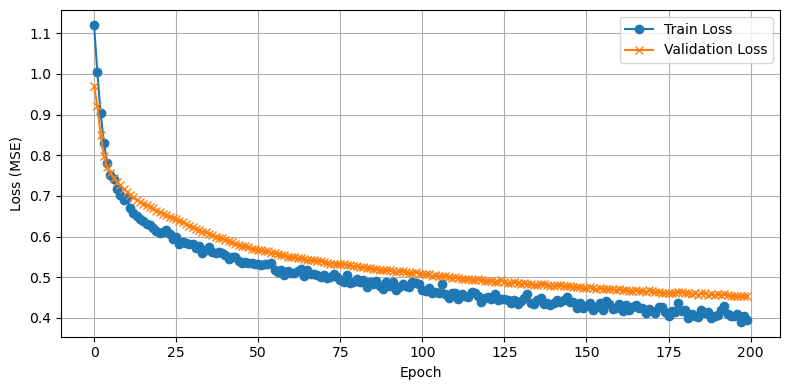

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Reconstructing single samples
Before we do any Clustering, let's see how good the model is in reconstructing one sample.

In [29]:
print(original_z.shape)

(342, 34974)


(342, 34974)


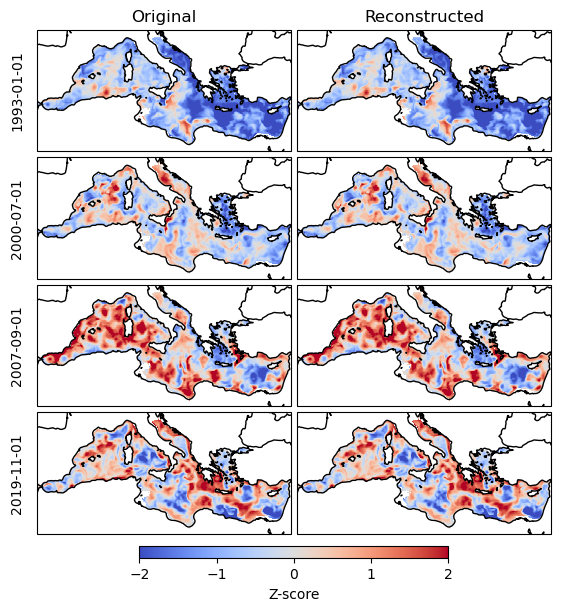

In [5]:
# X_recon_all = helper_functions.reconstruct_in_batches(X, model, device, 64)
original_z = helper_functions.preprocessing(ds, ["thetao"], [50], "location", -1)
print(original_z.shape)
importlib.reload(helper_functions)
coords = original_z.location  # z. B. aus dem preprocessing()
# reconstructed_z = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all, coords)
# print(reconstructed_z.shape)

helper_functions.plot_reconstruction_comparison(
    z_stack_original=original_z,
    z_stack_recon=original_z,# reconstructed_z,
    time_indices=[0, 90, 176, 322],
    cmin=-2,
    cmax=2
)

## Clustering with K-Means

### Clustering the reconstructions

### Latent = 3

In [10]:
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/notebooks/helper_functions.py'>

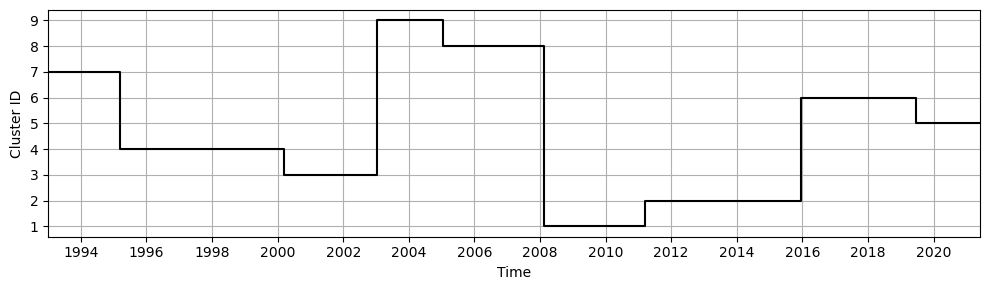

In [11]:
k=9
labels = helper_functions.apply_kmeans(X_recon_all, k)
labels += 1

helper_functions.plot_cluster_timeline(z_temp, labels)

### Depth = 50

In [12]:
recon_temp_50 = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

TypeError: reconstructed_to_stack() missing 1 required positional argument: 'coords'

In [ ]:
recon_so_50 = helper_functions.reconstructed_to_stack(ds, "so", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_so_50, labels, -2, 2)

### Depth = 300

In [ ]:
recon_temp_300 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_300, labels, -2, 2)

In [ ]:
recon_so_300 = helper_functions.reconstructed_to_stack(ds, "so", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_so_300, labels, -2, 2)

### Depth = 1000

In [ ]:
recon_temp_1000 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

In [ ]:
recon_so_1000 = helper_functions.reconstructed_to_stack(ds, "so", 1000, X_recon_all)
helper_functions.plot_average_cluster(recon_so_1000, labels, -2, 2)

### Latent clustering

In [ ]:
# import numpy as np
# import torch
# from sklearn.cluster import KMeans

# def encode_latents(model, X, batch_size=128):
#     """
#     X: NumPy array (n_samples, n_features)
#     model: trained autoencoder
#     returns: (n_samples, latent_dim)
#     """
#     model.eval()
#     latents = []

#     with torch.no_grad():
#         for i in range(0, len(X), batch_size):
#             batch = X[i:i+batch_size]
#             batch = torch.tensor(batch, dtype=torch.float32).to(device)
#             z = model.encoder(batch)
#             latents.append(z.cpu().numpy())

#     return np.concatenate(latents, axis=0)

# # 1. Latents berechnen
# latents_train = encode_latents(model, X_train)
# latents_test = encode_latents(model, X_test)
# latents_all = np.vstack([latents_train, latents_test])
# # 2. Clustering mit KMeans
# k = 9  # z.B. 5 Cluster
# kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
# labels = kmeans.fit_predict(latents_all)
# labels += 1


# helper_functions.plot_cluster_timeline(z_temp, labels)

# plot_cluster_average_reconstructions(
#     model=model,
#     X=np.vstack([X_train, X_test]),
#     labels=labels,
#     z_stack=z_stack,
#     num_clusters=k,
#     device=device
# )